# 1.0 Clustering Basic

In [3]:
# Uploading files from your local file system
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 114_congress.csv to 114_congress.csv
User uploaded file "114_congress.csv" with length 4394 bytes


## 1.1 Introduction




So far, we've looked at regression and classification. These are both types of [supervised machine learning](https://en.wikipedia.org/wiki/Supervised_learning). In supervised learning, you train an algorithm to predict an unknown variable from known variables.

Another major type of machine learning is called [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning). In unsupervised learning, we aren't trying to predict anything. Instead, we're finding patterns in data.

One of the main unsupervised learning techniques is called **clustering**. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. For example, we can cluster NBA players based on their statistics. Here's how such a clustering might look:

<center><img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1NUuctg1HZwvCQlFJTAYzsqgrhlDpi5VB"></center>


**The clusters made it possible to discover player roles that might not have been noticed otherwise**. [Here's](https://flowingdata.com/2012/03/21/redefining-nba-basketball-positions/) an article that describes how the clusters were created.

Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters. As we look at the clusters, we can start to better understand the structure of the data.

Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this lesson we'll work on **clustering US Senators based on how they voted.**

## 1.1 The dataset




In the US, the **Senate votes on proposed legislation**. Getting a bill passed by the Senate is a key step towards getting its provisions enacted. A **majority vote is required** to get a bill passed.

The results of these votes, known as roll call votes, are public, and available in a few places, including [here](https://github.com/unitedstates/congress). Read more about the US legislative system [here](https://en.wikipedia.org/wiki/Federal_government_of_the_United_States#Legislative_branch).

**Senators typically vote in accordance with how their political party votes**, known as voting along party lines. In the US, the 2 main political parties are the [Democrats](https://en.wikipedia.org/wiki/Democratic_Party), who tend to be [liberal](https://en.wikipedia.org/wiki/Liberalism), and the [Republicans](https://en.wikipedia.org/wiki/Republican_Party), who tend to be [conservative](https://en.wikipedia.org/wiki/Conservatism). **Senators** can also choose to be unaffiliated with a party, and vote as **Independents**, although very few choose to do so.

**114_congress.csv** contains all of the results of roll call votes from the **114th Senate**. Each row represents a single Senator, and each column represents a vote. A 0 in a cell means the Senator voted No on the bill, 1 means the Senator voted Yes, and 0.5 means the Senator abstained.

Here are the relevant columns:

- **name** -- The last name of the Senator.
- **party** -- the party of the Senator. The valid values are __D__ for Democrat, __R__ for Republican, and __I__ for Independent.
- Several columns numbered like **00001**, **00004**, etc. Each of these columns represents the results of a single roll call vote.

Below are the first three rows of the data. As you can see, the number of each bill is used as the column heading for its votes:

```python
name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
Alexander,R,TN,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
Ayotte,R,NH,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

**Clustering voting data of Senators is particularly interesting because it can expose patterns that go deeper than party affiliation**. For example, some Republicans are more liberal than the rest of their party. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Import the Pandas library.
- Use the **read_csv()** method in Pandas to read **114_congress.csv** into the variable **votes**.


In [0]:
# put your code here
import pandas as pd

votes = pd.read_csv('114_congress.csv')

## 1.2 Exploring the data

Now that we've read the data in, let's do some initial exploration of the data.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Find how many Senators are in each party.
  - Use the **value_counts()** method on the **party** column of **votes**. Print the results.
- Find what the "average" vote for each bill was.
  - Use the **mean()** method on the **votes** Dataframe. If the mean for a column is less than .5, more Senators voted against the bill, and vice versa if it's over .5. Print the results.


In [30]:
# put your code here

print(votes.party.value_counts())
print(votes.mean(axis=0))

R    54
D    44
I     2
Name: party, dtype: int64
00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64


## 1.3 Distance between Senators


To group Senators together, we need some way to figure out how "close" the Senators are to each other. **We'll then group together the Senators that are the closest**. We can actually discover this distance mathematically, by finding how similar the votes of two Senators are. The closer together the voting records of two Senators, the more ideologically similar they are (voting the same way indicates that you share the same views).

To find the distance between two rows, we can use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). The formula is:

$$d=\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+\ldots+(q_n-p_n)^2}$$

Let's say we have two Senator's voting records:

```python
name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
Alexander,R,TN,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
Ayotte,R,NH,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

If we took only the numeric vote columns, we'd have this:

```python
00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

If we wanted to compute the Euclidean distance, we'd plug the vote numbers into our formula:

$$d=\sqrt{(0-0)^2+(1-1)^2+(1-1)^2+(1-1)^2+(1-1)^2+(0-0)^2+\ldots+(0-0)^2}$$

As you can see, these Senators are very similar! If you look at the votes above, they only disagree on 3 bills. The final Euclidean distance between these two Senators is **1.73**.

To compute Euclidean distance in Python, we can use the [euclidean_distances()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html) method in the [scikit-learn](http://scikit-learn.org/stable/) library. The code below will find the Euclidean distance between the Senator in the first row and the Senator in the second row.

```python
euclidean_distances(votes.iloc[0,3:], votes.iloc[1,3:])
```

It's necessary to only select columns after the first 3 because the first 3 are name, party, and state, which aren't numeric.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Compute the **Euclidean distance** between the **first row** and the **third row**.
  - Assign the result to **distance**.
  - tip: use series.values.reshape(1,-1) in euclidean_distance parameters

In [0]:
# put your code here
from sklearn.metrics.pairwise import euclidean_distances

distance = euclidean_distances(votes.iloc[1,3:].values.reshape(1,-1), votes.iloc[3,3:].values.reshape(1,-1))

## 1.4 Initial clustering




We'll use an algorithm called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to split our data into clusters. k-means clustering uses Euclidean distance to form clusters of similar Senators. We'll dive more into the theory of k-means clustering and build the algorithm from the ground up in the later section. For now, it's important to understand clustering at a high level, so we'll leverage the [scikit-learn](http://scikit-learn.org/stable/) library to train a **k-means model.**

The **k-means** algorithm will **group Senators who vote similarly** on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. **From our background knowledge, we think that Senators will cluster along party lines**.

The k-means algorithm requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick 2 for our number of clusters.

We'll use the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class from scikit-learn to perform the clustering. **Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset.** After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:

```python
kmeans_model = KMeans(n_clusters=2, random_state=1)
```

The above code will initialize the k-means model with 2 clusters, and a random state of 1 to allow for the same results to be reproduced whenever the algorithm is run.

We'll then be able to use the [fit_transform()](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform) method to fit the model to **votes** and get the distance of each Senator to each cluster. The result will look like this:

```python
array([[ 3.12141628,  1.3134775 ],
   [ 2.6146248 ,  2.05339992],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 1.43833966,  2.96866004],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.31287498,  3.30758755],
   ...
```

This is a NumPy array with two columns. The first column is the Euclidean distance from each Senator to the first cluster, and the second column is the Euclidean distance to the the second cluster. The values in the columns will indicate how "far" the Senator is from each cluster. The further away from the cluster, the less the Senator's voting history aligns with the voting history of the cluster.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Use the **fit_transform()** method to fit **kmeans_model** on the **votes** DataFrame. Only select columns after the first 3 from **votes** when fitting.
- Assign the result to **senator_distances.**

In [0]:
# put your code here
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2,random_state=1)

senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])

## 1.5. Exploring the clusters




We can use the Pandas method [crosstab()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.crosstab.html) to compute and display how many Senators from each party ended up in each cluster. The **crosstab()** method takes in two vectors or Pandas Series and computes how many times each unique value in the second vector occurs for each unique value in the first vector.

Here's an example:

```python
is_smoker =       [0,1,1,0,0,1]
has_lung_cancer = [1,0,1,0,1,0]

pd.crosstab(np.array(has_lung_cancer),np.array(is_smoker),
          colnames=["has_lung_cancer"],rownames=["is_smoker"])

```

A 0 means False, and a 1 means True. A crosstab for the two above lists would look like this:

```python
has_lung_cancer    0     1
smoker
0                  1     2
1                  2     1
```

We can extract the cluster labels for each Senator from **kmeans_model** using **kmeans_model.labels_**, then we can make a table comparing these labels to **votes["party"]** with crosstab(). This will show us if the clusters tend to break down along party lines or not.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Use the **labels_** attribute to extract the labels from **kmeans_model**. Assign the result to the variable **labels**.
- Use the **crosstab()** method to print out a table comparing labels to **votes["party"]**, in that order.

In [33]:
# put your code here

labels = kmeans_model.labels_

pd.crosstab(labels,votes.party)

party,D,I,R
row_0,,,
0,41,2,0
1,3,0,54


## 1.6. Exploring Senators in the wrong cluster




It looks like both of our clusters mostly broke down along party lines. The first cluster contains **41** Democrats, and **two** Independents. The second cluster contains **3** Democrats, and **54** Republicans.

No Republicans seem to have broken party ranks to vote with the Democrats, but **3** Democrats are more similar to Republicans in their voting than their own party. Let's explore these **3** in more depth so we can figure out why that is.

We can do this by subsetting votes to only select rows where the party column is **D**, and the labels variable is **1**, indicating that the Senator is in the second cluster.

We can perform this subsetting with Pandas. The below code will select all Independents in the first cluster:

```python
votes[(labels == 0) & (votes["party"] == "I")]
```

When subsetting a DataFrame with multiple conditions, each condition needs to be in parentheses, and separated by **&**.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Select all senators who were assigned to the second cluster that were Democrats. Assign the subset to **democratic_outliers**.
- Print out **democratic_outliers.**

In [34]:
#put your code here

democratic_outliers = votes[(labels == 1) & (votes["party"] == "D")]
print(democratic_outliers)

        name party state  00001  00004  00005  00006  00007  00008  00009  \
42  Heitkamp     D    ND    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
56   Manchin     D    WV    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
74      Reid     D    NV    0.5    0.5    0.5    0.5    0.5    0.5    0.5   

    00010  00020  00026  00032  00038  00039  00044  00047  
42    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  
56    1.0    1.0    0.0    0.0    1.0    1.0    0.0    0.0  
74    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5  


## 1.7 Plotting out the clusters

One great way to explore clusters is to visualize them using **matplotlib**. Earlier, we computed a **senator_distances** array that shows the distance from each Senator to the center of each cluster. We can treat these distances as x and y coordinates, and make a scatterplot that shows the position of each Senator. This works because the distances are relative to the cluster centers.

While making the scatterplot, we can also shade each point according to party affiliation. This will enable us to quickly look at the layout of the Senators, and see who crosses party lines.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Make a scatterplot using [plt.scatter()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter). Pass in the following keyword arguments:
  - **x** should be the first column of **senator_distances.**
  - **y** should be the second column of **senator_distances.**
  - **c** should be **labels**. This will shade the points according to label.
  - **cmap** should be set to "RdBu"
- Use **plt.show()** to show the plot.

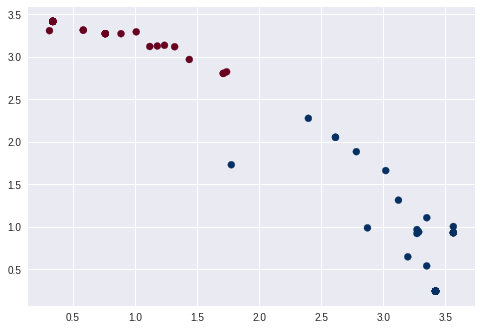

In [35]:
# put your code here

import matplotlib.pyplot as plt

plt.scatter(senator_distances[:,0],senator_distances[:,1],c=labels,cmap="RdBu")
plt.show()

## 1.8 Finding the most extreme




The **most extreme** Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall in between the views of the two parties.

If we look at the first few rows of **senator_distances**, we can start to see who is more extreme:

>```python
[
       [ 3.12141628,  1.3134775 ], # Slightly moderate, far from cluster 1, close to cluster 2.
       [ 2.6146248 ,  2.05339992], # Moderate, far from cluster 1, far from cluster 2.
       [ 0.33960656,  3.41651746], # Somewhat extreme, very close to cluster 1, very far from cluster 2.
       [ 3.42004795,  0.24198446], # Fairly extreme, very far from cluster 1, very close to cluster 2.
       ...
   ]
```

We'll create a formula to find extremists -- we'll cube the distances in both columns of **senator_distances**, then add them together. The higher the exponent we raise a set of numbers to, the more separation we'll see between small values and low values. For instance, squaring [1,2,3] results in [1,4,9], and cubing it results in [1,8,27].

We cube the distances so that we can get a good amount of separation between the extremists who are farther away from a party, who have distances that look like extremist = [3.4, .24], and moderates, whose distances look like moderate = [2.6, 2]. If we left the distances as is, we'd end up with 3.4 + .24 = 3.64, and 2.6 + 2 = 4.6, which would make the moderate, who is between both parties, seem extreme. If we cube, we instead end up with $3.4^ 3 + .24^3 = 39.3$, and $2.6^3 + 2^3 = 25.5$, which correctly identifies the extremist.

Here's how the first few ratings would look:

```python
[
       [ 3.12141628,  1.3134775 ], # 32.67
       [ 2.6146248 ,  2.05339992], # 26.5
       [ 0.33960656,  3.41651746], # 39.9
       [ 3.42004795,  0.24198446], # 40
       ...
   ]
```

We can cube every value in **senator_distances** by typing $senator\_distances^3$. To find the sum across every row, we'll need to use the NumPy [sum()](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html) method, and pass in the keyword argument axis=1.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



- Compute an extremism rating by cubing every value in **senator_distances**, then finding the **sum** across each row. Assign the result to **extremism.**
- Assign the **extremism** variable to the **extremism** column of **votes**.
- Sort **votes** on the **extremism** column, in **descending** order, using the **sort_values()** method on DataFrames.
- Print the top 10 most extreme Senators.

In [0]:
# put your code here
import numpy as np

extremism = np.sum(senator_distances**3,axis=1)
votes['extremism'] = extremism

In [45]:
votes = votes.sort_values(by='extremism',ascending=False)
votes.head(n=10)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,extremism
98,Wicker,R,MS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.250476
26,Cruz,R,TX,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
53,Lankford,R,OK,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
69,Paul,R,KY,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
80,Sasse,R,NE,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
27,Daines,R,MT,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
40,Hatch,R,UT,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
77,Rounds,R,SD,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
18,Coats,R,IN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
6,Blunt,R,MO,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540


## 1.9 Next steps




**Clustering is a powerful way to explore data and find patterns.** Unsupervised learning is very commonly used with large datasets where it isn't obvious how to start with supervised machine learning. In general, it's a good idea to try unsupervised learning to explore a dataset before trying to use supervised learning machine learning models.

In the next section, we'll dive more into the **k-means** clustering algorithm and build our own from the ground up.



# 2.0 K-means clustering

In [2]:
# Uploading files from your local file system
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving nba_2013.csv to nba_2013.csv
User uploaded file "nba_2013.csv" with length 72021 bytes


## 2.1 Clustering NBA Players

In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. With our data science hats on, we can't help but feel a slight sense of skepticism to how different the players are from one another. Let's see how we can use data science to explore that thread further.

Let's look at the dataset of player performance from the 2013-2014 season.

Here are some selected columns:

- **player** -- name of the player
- **pos** -- the position of the player
- **g** -- number of games the player was in
- **pts** -- total points the player scored
- **fg.** -- field goal percentage
- **ft.** -- free throw percentage

Check out [Database Basketball](https://www.rotowire.com/basketball/stats.php?season=2013) for an explanation of all the columns

In [36]:
import pandas as pd
import numpy as np

# visualize more columns
pd.set_option('display.max_columns', 50)

nba = pd.read_csv("nba_2013.csv")
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013


## 2.2 Point Guards


**Point guards** play one of the most crucial roles on a team because their **primary responsibility is to create scoring opportunities** for the team. We are going to focus our lesson on a machine learning technique called **clustering**, which allows us to visualize the types of point guards as well as group similar point guards together. **Using 2 features** allows us to easily visualize the players and will also make it easier to grasp how clustering works. For point guards, it's widely accepted that the **Assist to Turnover Ratio** is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use **Points Per Game**, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves


<center><img width="300" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1TRx73TAAQozxnflLXPhWXuDbM-Q2KHh4"></center>



**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Create a new Dataframe which contains just the point guards from the data set.
  - Point guards are specified as **PG** in the **pos** column.
- Assign the filtered data frame to **point_guards**.


In [37]:
# put your code here

point_guards = nba[nba.pos=='PG']
point_guards.head(n=10)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,133,332,0.400602,165,386,0.427461,0.508,201,227,0.885,15,115,130,313,53,3,125,147,930,2013-2014,2013
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,7,25,0.280000,49,106,0.462264,0.454,31,39,0.795,5,32,37,32,7,4,19,30,150,2013-2014,2013
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,73,231,0.316017,181,425,0.425882,0.443,79,100,0.790,16,138,154,303,26,0,125,129,660,2013-2014,2013
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,76,212,0.358491,172,405,0.424691,0.464,94,118,0.797,22,123,145,194,60,9,82,161,666,2013-2014,2013
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,79,210,0.376190,54,143,0.377622,0.489,33,43,0.767,13,146,159,307,54,8,102,85,378,2013-2014,2013
52,Eric Bledsoe,PG,24,PHO,43,40,1416,265,556,0.477,50,140,0.357143,215,416,0.516827,0.522,183,237,0.772,27,175,202,235,69,14,143,99,763,2013-2014,2013
60,Avery Bradley,PG,23,BOS,60,58,1855,361,825,0.438,79,200,0.395000,282,625,0.451200,0.485,90,112,0.804,48,178,226,85,63,11,96,145,891,2013-2014,2013
64,Aaron Brooks,PG,29,TOT,72,12,1557,233,581,0.401,96,248,0.387097,137,333,0.411411,0.484,83,95,0.874,43,97,140,233,52,13,117,146,645,2013-2014,2013
71,Trey Burke,PG,21,UTA,70,68,2262,341,897,0.380,111,336,0.330357,230,561,0.409982,0.442,102,113,0.903,37,171,208,396,42,6,131,145,895,2013-2014,2013
76,Dwight Buycks,PG,24,TOR,14,0,146,15,48,0.313,5,17,0.294118,10,31,0.322581,0.365,8,9,0.889,4,19,23,10,8,0,10,11,43,2013-2014,2013


## 2.3 Points Per Game

While our dataset doesn't come with **Points Per Game** values, we can easily calculate those using each player's total points (**pts**) and the number of games (**g**) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game **ppg** column by dividing the pts and g columns.

In [38]:
# put your code here
point_guards["ppg"] = point_guards['pts']/point_guards['g']
point_guards.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end,ppg
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,133,332,0.400602,165,386,0.427461,0.508,201,227,0.885,15,115,130,313,53,3,125,147,930,2013-2014,2013,13.098592
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,7,25,0.280000,49,106,0.462264,0.454,31,39,0.795,5,32,37,32,7,4,19,30,150,2013-2014,2013,7.500000
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,73,231,0.316017,181,425,0.425882,0.443,79,100,0.790,16,138,154,303,26,0,125,129,660,2013-2014,2013,8.354430
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,76,212,0.358491,172,405,0.424691,0.464,94,118,0.797,22,123,145,194,60,9,82,161,666,2013-2014,2013,9.250000
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,79,210,0.376190,54,143,0.377622,0.489,33,43,0.767,13,146,159,307,54,8,102,85,378,2013-2014,2013,6.872727


## 2.4 Assist Turnover Ratio

Now let's create a column, **atr**, for the Assist Turnover Ratio, which is calculated by dividing total assists (**ast**) by total turnovers (**tov**):

$$
\displaystyle atr = \frac{ast}{tov}
$$

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Drop the players who have 0 turnovers.
  - Not only did these players only play a few games, making it hard to understand their true abilities, but we also cannot divide by 0 when we calculate **atr**.
- Utilize the same division technique we used with Points Per Game to create the Assist Turnover Ratio (**atr**) column for **point_guards.**

In [39]:
# put your code here
point_guards = point_guards[point_guards['tov']!=0]
point_guards['atr'] = point_guards['ast']/point_guards['tov']
point_guards.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,133,332,0.400602,165,386,0.427461,0.508,201,227,0.885,15,115,130,313,53,3,125,147,930,2013-2014,2013,13.098592,2.504000
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,7,25,0.280000,49,106,0.462264,0.454,31,39,0.795,5,32,37,32,7,4,19,30,150,2013-2014,2013,7.500000,1.684211
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,73,231,0.316017,181,425,0.425882,0.443,79,100,0.790,16,138,154,303,26,0,125,129,660,2013-2014,2013,8.354430,2.424000
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,76,212,0.358491,172,405,0.424691,0.464,94,118,0.797,22,123,145,194,60,9,82,161,666,2013-2014,2013,9.250000,2.365854
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,79,210,0.376190,54,143,0.377622,0.489,33,43,0.767,13,146,159,307,54,8,102,85,378,2013-2014,2013,6.872727,3.009804


## 2.5 Visualizing the Point Guards

Use **matplotlib** to create a **scatter** plot with Points Per Game (**ppg**) on the X axis and Assist Turnover Ratio (**atr**) on the Y axis.


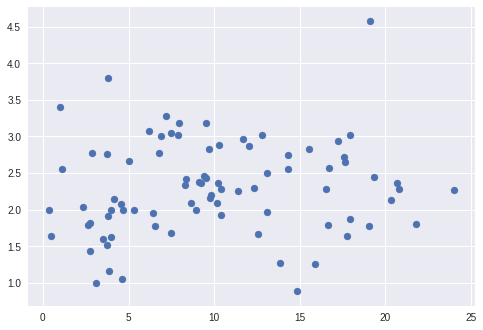

In [40]:
# put your code here
import matplotlib.pyplot as plt

plt.scatter(point_guards['ppg'],point_guards['atr'])
plt.show()

## 2.6 Clustering players

**There seem to be 5 general regions**, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use **unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.**

There are multiple ways of clustering data but here we will focus on **centroid based clustering** for this lesson. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). **The centroid represent the arithmetic mean of all of the data points in that cluster.**

**K-Means Clustering is a popular centroid-based clustering algorithm that we will use.** The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

## 2.7 The Algorithm

Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. **To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.**

- **Step 1 (Assign Points to Clusters)** - for each player, calculate the Euclidean distance between that player's coordinates, or values for **atr & ppg**, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

- **Step 2 (Update New Centroids of the Clusters)** - for each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

- Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.




In [0]:
import numpy as np

num_clusters = 5

# Use numpy's random function to generate a list, 
# length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)

# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]


### 2.7.1 Visualize the centroids


Let's plot the **centroids**, in addition to the **point_guards**, so we can see where the randomly chosen centroids started out.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Plot a scatter figure using **ppg** and **atr** from **point_guards**.
- In the same figure,  create a scatter plot using **ppg** and **atr** from **centroids**.

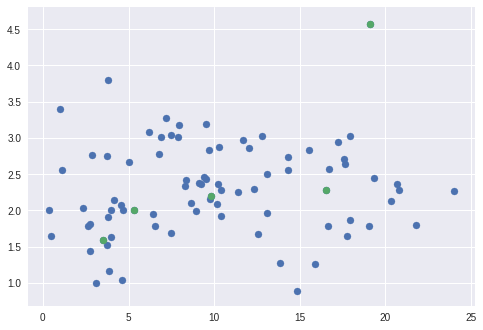

In [42]:
# put your code here
plt.scatter(point_guards['ppg'],point_guards['atr'])
plt.scatter(centroids['ppg'],centroids['atr'])
plt.show()

### 2.7.2 Setup (continued)

While the **centroids** dataframe object worked well for the initial centroids, where the centroids were just a subset of players, as we iterate the centroids' values will be coordinates that may not match another player's coordinates. Moving forward, **let's use a dictionary object instead to represent the centroids.**

We will need a unique identifier, like **cluster_id**, to refer to each cluster's centroid and a list representation of the centroid's coordinates (or values for **ppg** and **atr**). Let's create a dictionary then with the following mapping:

- key: **cluster_id** of that centroid's cluster
- value: centroid's coordinates expressed as a list ( **ppg** value first, **atr** value second )

To generate the **cluster_ids**, let's iterate through each centroid and assign an integer from 0 to k-1. For example, the first centroid will have a **cluster_id** of 0, while the second one will have a **cluster_id** of 1. We'll write a function, **centroids_to_dict**, that takes in the centroids data frame object, creates a **cluster_id** and converts the **ppg** and **atr** values for that centroid into a list of coordinates, and adds both the **cluster_id** and **coordinates_list** into the dictionary that's returned.



In [0]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

### 2.7.3 Step 1 (Euclidean Distance)

Before we can assign players to clusters, we need a way to compare the **ppg** and **atr** values of the players with each cluster's centroids. **Euclidean distance** is the most common technique used in data science for measuring distance between vectors and works extremely well in 2 and 3 dimensions. While in higher dimensions, Euclidean distance can be misleading, in 2 dimensions Euclidean distance is essentially the **Pythagorean theorem**. The formula is :


$$\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+\ldots+(q_n-p_n)^2}$$


where **q** and **p** are the 2 vectors we are comparing. If **q** is **[5, 2]** and **p** is **[3, 1]**, the distance comes out to:

$$\sqrt{(5-3)^2+(2-1)^2} = \sqrt{5} =2.24 $$

Let's create the function **calculate_distance**, which takes in 2 lists (the player's values for **ppg** and **atr** and the centroid's values for **ppg** and **atr**).


In [44]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))


2.23606797749979


### 2.7.4 Step 1 (Continued)

Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the **point_guards** data frame that contains the **cluster_id** of the cluster it belongs to.

Note: Even though we don't seed the random numbers to generate the centroids, the answer is seeded and will produce the same results everytime.

In [0]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

### 2.7.5 Visualizing Clusters

Let's write a function, **visualize_clusters**, that we can use to visualize the clusters easily.

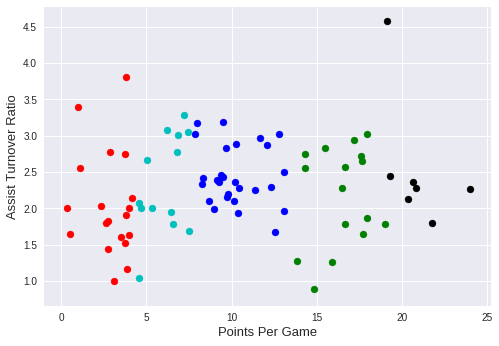

In [46]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

### 2.7.6 Step 2


How colorful! Now let's code Step 2, where we recalculate the centroids for each cluster.

In [0]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']), 
                        np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

### 2.7.7 Repeat Step 1

Now that we recalculated the centroids, let's re-run Step 1 (**assign_to_cluster**) and see how the clusters shifted.



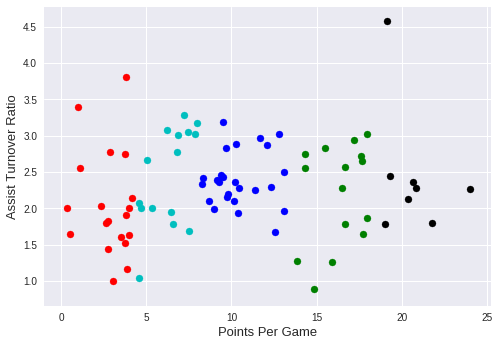

In [48]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


### 2.7.8 Repeat Step 2 and Step 1

Now we need to recalculate the centroids, and shift the clusters again.



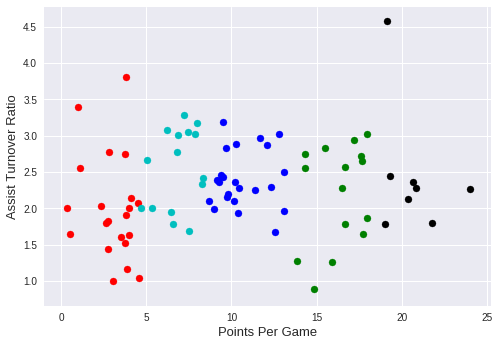

In [49]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


## 2.8 Challenges of K-Means

As you repeat Steps 1 and 2 and run **visualize_clusters**, you'll notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

- K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable
- Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot

To counteract these problems, the **sklearn** implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

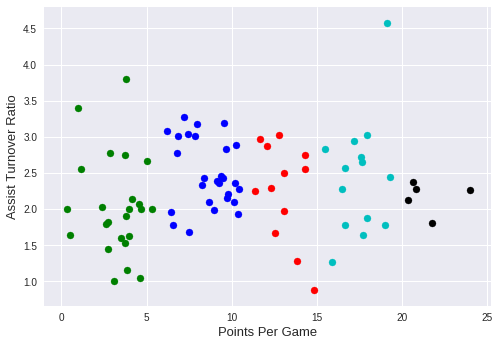

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)


## 2.9 Conclusion

In this lesson, we explored how to segment NBA players into groups with similar traits. Our exploration helped us get a sense of the 5 types of point guards as based on each player's Assist Turnover Ratio and Points Per Game. In future challenges, you can explore how to cluster using many more features, as well as alternative ways of clustering data without using centroids.

We also got to experience the beauty of sklearn and the simplicity of using sophisticated models to get what we need accomplished quickly. In just a few lines, we ran and visualized the results of a robust K-means clustering implementation. When using K-means in the real world, use the sklearn implementation.